# 🧩 Reto 4 – Integración de resultados
**Objetivo:** combinar resultados parciales en un diagnóstico integral por sitio.

### Pasos
1. Carga `resultado_temperatura.csv`, `resultado_ph.csv`, `resultado_oxigeno.csv`.
2. Únelos por `sitio` usando `merge`.
3. Crea `diagnostico_final` con reglas (parcial/total/normal).
4. Exporta `diagnostico_final.csv`.
5. Cuenta categorías con `value_counts()`.
> **Reto adicional:** gráfico de barras de distribución.

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Directorio donde están los CSV
BASE = Path(r"c:\Users\USUARIO\Documents\trabajo\4-condicionales-grupo_4\notebooks")

r_temp = BASE / 'resultado_temperatura.csv'
r_ph = BASE / 'resultado_ph.csv'
r_oxi = BASE / 'resultado_oxigeno.csv'

# Cargar si existen
dfs = {}
for key, path in [('temperatura', r_temp), ('ph', r_ph), ('oxigeno', r_oxi)]:
    if path.exists():
        dfs[key] = pd.read_csv(path)
        print(f"Cargado {path.name}: {dfs[key].shape[0]} filas, {dfs[key].shape[1]} columnas")
    else:
        print(f"No encontrado: {path.name} en {BASE}")


No encontrado: resultado_temperatura.csv en c:\Users\USUARIO\Documents\trabajo\4-condicionales-grupo_4\notebooks
Cargado resultado_ph.csv: 10 filas, 3 columnas
Cargado resultado_oxigeno.csv: 10 filas, 4 columnas


In [3]:
# Normalizar columna 'sitio' y renombrar columnas de resultado
def ensure_sitio(df):
    df = df.copy()
    if 'sitio' not in df.columns:
        cand = [c for c in df.columns if 'sitio' in c.lower() or 'site' in c.lower()]
        if cand:
            df = df.rename(columns={cand[0]: 'sitio'})
    return df

def rename_result(df, prefix):
    df = df.copy()
    cols = [c for c in df.columns if c != 'sitio']
    if len(cols) == 1:
        df = df.rename(columns={cols[0]: f'res_{prefix}'})
    else:
        for c in cols:
            df = df.rename(columns={c: f'{prefix}_{c}'})
    return df

to_merge = []
if 'temperatura' in dfs:
    to_merge.append(rename_result(ensure_sitio(dfs['temperatura']), 'temp'))
if 'ph' in dfs:
    to_merge.append(rename_result(ensure_sitio(dfs['ph']), 'ph'))
if 'oxigeno' in dfs:
    to_merge.append(rename_result(ensure_sitio(dfs['oxigeno']), 'oxi'))

if not to_merge:
    raise FileNotFoundError('No se encontraron archivos para integrar en la carpeta notebooks')

from functools import reduce
df_int = reduce(lambda a, b: pd.merge(a, b, on='sitio', how='outer'), to_merge)
print('\nData integrado:', df_int.shape)
display(df_int.head())

# Clasificar pH numérico/textual: =7 neutro, >7 basico, <7 acido
df = df_int.copy()
ph_cols = [c for c in df.columns if 'ph' in c.lower() and c != 'sitio']
ph_col = ph_cols[0] if ph_cols else None
print('Columna pH detectada:', ph_col)

def ph_clase(x):
    if pd.isna(x):
        return None
    try:
        v = float(x)
    except Exception:
        s = str(x).strip().lower()
        if 'neutr' in s:
            return 'neutro'
        if 'bas' in s or 'alc' in s:
            return 'basico'
        if 'acid' in s or 'ácid' in s:
            return 'acido'
        return None
    if v == 7:
        return 'neutro'
    if v > 7:
        return 'basico'
    return 'acido'

df['ph_clas'] = df[ph_col].apply(ph_clase) if ph_col else None
print('\nDistribución pH clasificada:')
print(df['ph_clas'].value_counts(dropna=False))

# Crear diagnostico_final: prioridad total > parcial > normal
def diagnostico_fila(r):
    textos = []
    for c in r.index:
        if c in ('sitio', 'ph_clas'):
            continue
        v = r[c]
        if pd.isna(v):
            continue
        textos.append(str(v).lower())
    if any('total' in t for t in textos):
        return 'total'
    if any('parcial' in t for t in textos):
        return 'parcial'
    return 'normal'

df['diagnostico_final'] = df.apply(diagnostico_fila, axis=1)
display(df[['sitio','ph_clas','diagnostico_final']].head())


Data integrado: (10, 6)


,sitio,ph_pH,ph_clasificacion_pH,oxi_oxigeno,oxi_nivel_oxigeno,oxi_riesgo_biologico
0,Afluente San José (El Rosal),7.9,Neutro,8.3,alto,NaN
1,Quebrada Cune (San Francisco),6.0,Alerta_quimica,4.5,bajo,⚠
2,Quebrada Honda (Facatativá),6.3,Alerta_quimica,6.2,medio,NaN
3,Quebrada Negra (La Vega),7.6,Neutro,7.0,medio,NaN
4,Río Bahamón (Sasaima),8.1,Neutro,6.7,medio,NaN


Columna pH detectada: ph_pH

Distribución pH clasificada:
ph_clas
basico    6
acido     4
Name: count, dtype: int64


,sitio,ph_clas,diagnostico_final
0,Afluente San José (El Rosal),basico,normal
1,Quebrada Cune (San Francisco),acido,normal
2,Quebrada Honda (Facatativá),acido,normal
3,Quebrada Negra (La Vega),basico,normal
4,Río Bahamón (Sasaima),basico,normal


In [4]:
# Exportar
OUT = BASE / 'diagnostico_final.csv'
df.to_csv(OUT, index=False)
print('\nExportado ->', OUT)

# Conteos
print('\nConteo diagnósticos:')
print(df['diagnostico_final'].value_counts(dropna=False))


Exportado -> c:\Users\USUARIO\Documents\trabajo\4-condicionales-grupo_4\notebooks\diagnostico_final.csv

Conteo diagnósticos:
diagnostico_final
normal    10
Name: count, dtype: int64


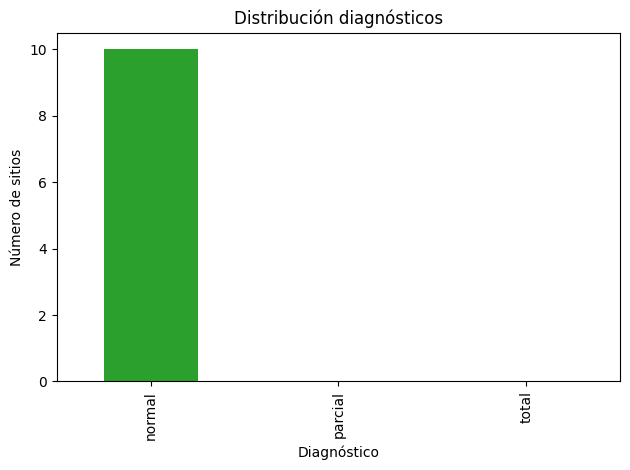

In [5]:
# Gráfico opcional (barras)
ax = df['diagnostico_final'].value_counts().reindex(['normal','parcial','total']).fillna(0).plot.bar(color=['#2ca02c','#ff7f0e','#d62728'])
ax.set_title('Distribución diagnósticos')
ax.set_xlabel('Diagnóstico')
ax.set_ylabel('Número de sitios')
plt.tight_layout()
plt.show()